In [ ]:
#instructions for how to build this using nbdev at https://nbdev.fast.ai/

In [ ]:
#default_exp predict

# Predict loaded articles

> Takes a loader as an argument

In [ ]:
#export
from newstrends import loader
import pandas as pd
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
class predicter(loader.article_holder):
    
    def __init__(self):
        super().__init__()

        

In [ ]:
#export
class predicter(predicter):
    def getOneStepForecast(self, steps:int=1, model:str="sarimax"):
        print(df.columns)
        return -1
    


In [ ]:
tmp = loader.article_holder()
tmp.set_articleDir(path="../CoverageTrends")
tmp.load_articles(publications=["newyorktimes", "washingtonpost"])


In [ ]:
#export
class predicter(predicter):
    def transformTimeSeries(self, keyword:str="", publishers:list=[], timeStart=-1, timeEnd=-1, aggregate="h"):   
        if keyword == "":
            raise Exception("Pass a keyword")
        if type(keyword)!=str:
            raise Exception("Pass keyword as a string")

        df= self.df.copy()
        df = df[df.tokens.apply(lambda x: keyword in x)]
                    
        df.date = pd.to_datetime(df.date)
        df.set_index("date", inplace=True)

        newDF = pd.DataFrame()
        for src in publishers:
            newDF[src] = df[df.source==src].resample(aggregate).count()["quickReplace"]
        df=newDF
        if len(df) < 1:
            raise Exception("No data in time series")
        self.timeDF = df.fillna(0)

    

In [ ]:
class predicter(predicter):
    def test_train_split(self, testSize):
        if testSize > 0:
            self.train=self.timeDF[:-testSize]
            self.test=self.timeDF[-testSize:]
        else:
            self.train=self.timeDF

In [ ]:
#export
class predicter(predicter):
    
    def simpleSarimaxModel(self, endogenous:str, exogenous=[], indexStart=-1, indexEnd=-1, aggregate="h", m=24, ic:["oob", "aic"]="oob"):
        
        try:
            if len(self.train) < 1:
                raise Exception("")
            
        except:
            raise Exception("No transformed time series; run test_train split")
            
        
        mDict={
            "D":7,
            "h":24,
        }
        try:
            m=mDict[aggregate]
        except:
            pass
        
        df = self.timeDF.resample(aggregate).sum()
        
        if indexStart > 0:
            df=df[indexStart:]

        
        endo = df[[endogenous]]

        if len(exogenous) > 0:
            endo = endo[1:]
            exog = df[exogenous].shift()[1:]
            model = auto_arima(endo, exogenous=exog, out_of_sample_size=3*m, information_criterion=ic, m=m, stepwise=True, trace=True)
        

        else:
            model = auto_arima(endo, out_of_sample_size=24, information_criterion=ic, m=m, stepwise=True, trace=True)
        

        return model

# what we need to do is make a model for our endogenous and exogenous series on the training set. Then, to keep the trained model results without changing them we fit a new model to the full (or test) data set and then filter it on the original params
(see https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)

In [ ]:
p = predicter()
p.load_article_holder(tmp)
p.transformTimeSeries(keyword="floyd", publishers=["newyorktimes", "washingtonpost"])
p.test_train_split(48)

In [ ]:
model = p.simpleSarimaxModel("newyorktimes", exogenous=["washingtonpost"], aggregate="h")

Performing stepwise search to minimize oob
Fit ARIMA: (2, 0, 2)x(1, 0, 1, 24) (constant=True); AIC=1021.314, BIC=1057.460, Time=4.430 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=True); AIC=1642.447, BIC=1654.496, Time=0.096 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 24) (constant=True); AIC=1036.365, BIC=1056.446, Time=1.143 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 24) (constant=True); AIC=1326.047, BIC=1346.128, Time=1.190 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=False); AIC=1678.089, BIC=1686.121, Time=0.090 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 24) (constant=True); AIC=1325.061, BIC=1341.126, Time=0.147 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 1, 24) (constant=True); AIC=1327.305, BIC=1351.402, Time=2.104 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 0, 24) (constant=True); AIC=1325.746, BIC=1345.827, Time=1.006 seconds
Fit ARIMA: (0, 0, 1)x(2, 0, 1, 24) (constant=True); AIC=1329.140, BIC=1357.254, Time=7.625 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 2, 24) (constant=True); AIC=1329.142,

In [ ]:
endogenous="newyorktimes"
endo = p.timeDF[[endogenous]][1:]
exog = p.timeDF[[x for x in p.timeDF.columns if x != endogenous]].shift()[1:]

In [ ]:
tmp = SARIMAX(endo, exogenous=exog, order = model.order, seasonal_order=model.seasonal_order)

In [ ]:
res = tmp.filter(model.params())

In [ ]:
endo["yhat"] = res.predict(exogenous=exog)

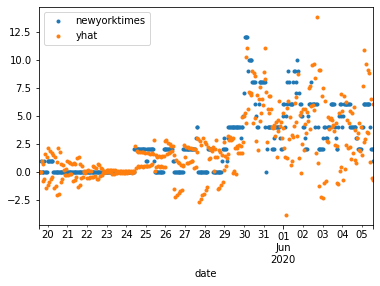

In [ ]:
endo.plot(style=".")

In [ ]:
endo["resid"] = endo[endogenous]-endo.yhat

In [ ]:
endo["percent_error"] = 100*np.abs(endo["resid"]/endo[endogenous])

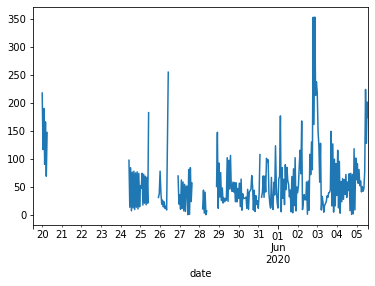

In [ ]:
endo["percent_error"].plot()

In [ ]:
endo

,newyorktimes
date,
2020-05-19 13:00:00,0
2020-05-19 14:00:00,0
2020-05-19 15:00:00,0
2020-05-19 16:00:00,1
2020-05-19 17:00:00,0
...,...
2020-06-05 10:00:00,4
2020-06-05 11:00:00,2
2020-06-05 12:00:00,2


In [ ]:
testing=p.test[["newyorktimes"]]

In [ ]:
testing["yhat"] = endo["newyorktimes"]

In [ ]:
model

ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 2), out_of_sample_size=72,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 2, 24),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [ ]:
#export
class predicter(predicter):
    "generate best model for each series in the loaded time series dataframe"
    def generateMultivarSARIMAXResults(self):
        self.multiVarResults = {}
        
        for publication in self.test.columns:
            #hmm, doing for arbetrary numbers, I should be able to assume that pvalues/params of i correspond
            self.multiVarResults[publication] = {}
            
            endogenous = publication
            exogenous = [x for x in self.test.columns if x != publication]
            
            endo = endo[1:]
            exog = df[exogenous].shift()[1:]
            model = auto_arima(endo, exogenous=exog, out_of_sample_size=3*m, information_criterion=ic, m=m, stepwise=True, trace=True)
            
            endo = self.timeDF[[endogenous]][1:].copy()
            exog = self.timeDF[exogenous].shift()[1:]

            if model.with_intercept:
                newModel = SARIMAX(endo, exog=exog, order = model.order, seasonal_order=model.seasonal_order, trend='c')
            else:
                newModel = SARIMAX(endo, exog=exog, order = model.order, seasonal_order=model.seasonal_order)
                
            newModel = newModel.filter(model.params())
            
            endo["yhat"] = newModel.predict(exogenous=exog)
                        
            self.multiVarResults[publication]["params"] = newModel.params
            self.multiVarResults[publication]["pvalues"] = newModel.pvalues
            self.multiVarResults[publication]["results"] = endo
            
        
            

In [ ]:
tmp = loader.article_holder()
tmp.set_articleDir(path="../CoverageTrends")
tmp.load_articles(publications=["newyorktimes", "washingtonpost"])


p = predicter()
p.load_article_holder(tmp)
p.transformTimeSeries(keyword="floyd", publishers=["newyorktimes", "washingtonpost"])
p.test_train_split(48)

In [ ]:
p.generateMultivarSARIMAXResults()

Performing stepwise search to minimize oob
Fit ARIMA: (2, 0, 2)x(1, 0, 1, 24) (constant=True); AIC=1021.314, BIC=1057.460, Time=4.792 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=True); AIC=1642.447, BIC=1654.496, Time=0.102 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 24) (constant=True); AIC=1036.365, BIC=1056.446, Time=1.179 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 24) (constant=True); AIC=1326.047, BIC=1346.128, Time=1.210 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=False); AIC=1678.089, BIC=1686.121, Time=0.094 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 24) (constant=True); AIC=1325.061, BIC=1341.126, Time=0.150 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 1, 24) (constant=True); AIC=1327.305, BIC=1351.402, Time=2.238 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 0, 24) (constant=True); AIC=1325.746, BIC=1345.827, Time=1.065 seconds
Fit ARIMA: (0, 0, 1)x(2, 0, 1, 24) (constant=True); AIC=1329.140, BIC=1357.254, Time=7.700 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 2, 24) (constant=True); AIC=1329.142,

In [ ]:
pd.DataFrame(p.multiVarResults)

,newyorktimes,washingtonpost
params,intercept 1.269209 washingtonpost 0...,newyorktimes 0.172732 sigma2 2.462...
pvalues,intercept 1.080625e-06 washingtonpost...,newyorktimes 6.907657e-03 sigma2 ...
results,newyorktimes yhat da...,washingtonpost yhat...


# Determining how error changes depending on size/time of training set

In [ ]:
#export
def get_mse(df):
    """calculate MSE of df, assuming column1 is actual column2 is predicted"""
    true = df.columns[0]
    predicted = df.columns[1]
    
    return ((df[true]-df[predicted])**2).mean()

In [ ]:
#export
class predicter(predicter):
    """
    It can be hard to know when to start modeling a series, how does the start date influence error?
    """
    def get_sarimax_starting_errors(self, topic="", endogSeries:str="", exogSeries:list=[], units:int=1)->pd.DataFrame:
        """
        Takes a topic, engogenous publisher (str) and possible exogenous variables
        returns errors for test set over time
        """
        
        results = {}
        
        df = self.train.copy()
        
        current_start = 0
        indices = df.index.to_list()
        while current_start < len(df):
            try:
                model = self.simpleSarimaxModel(endogSeries, exogenous=exogSeries, indexStart=current_start)
            except:
                break

            endo=self.timeDF[[endogSeries]][1:]

            kwargs = {}
            kwargs["order"] = model.order
            kwargs["seasonal_order"] = model.seasonal_order
            if model.with_intercept:
                kwargs["trend"]='c'
            if len(exogSeries) > 0:
                exog=timeDF[exogSeries].shift()[1:]
                kwargs["exog"] = exog

            newModel = SARIMAX(endo, **kwargs)
            newModel = newModel.filter(model.params())
            
            if len(exogSeries) > 0:
                endo["yhat"] = newModel.predict(exogenous=exog)
            else:
                endo["yhat"] = newModel.predict()

            scoring = self.test[[endogSeries]].copy()
            scoring["yhat"] = endo["yhat"]

            results[indices[current_start]] = scoring
            self.results = results
            current_start += units

        
    

## I test this on seeing how models of floyd perform. Of course, since this is using a validation set, the model just does really really poorly when the training set mostly covers the time period the scraper was down.

In [ ]:
p = predicter()
p.load_article_holder(tmp)
p.transformTimeSeries(keyword="floyd", publishers=["newyorktimes", "washingtonpost"])
p.test_train_split(48)

In [ ]:
p.get_sarimax_starting_errors(topic = "floyd", endogSeries="newyorktimes", units=10)

Performing stepwise search to minimize oob
Fit ARIMA: (2, 1, 2)x(1, 0, 1, 24) (constant=True); AIC=1016.633, BIC=1048.762, Time=4.429 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 24) (constant=True); AIC=1042.180, BIC=1050.213, Time=0.078 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 24) (constant=True); AIC=1030.066, BIC=1046.131, Time=0.656 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 24) (constant=True); AIC=1027.797, BIC=1043.861, Time=0.747 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 24) (constant=False); AIC=1040.180, BIC=1044.196, Time=0.029 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 24) (constant=True); AIC=1032.735, BIC=1044.784, Time=0.083 seconds
Fit ARIMA: (1, 1, 0)x(2, 0, 0, 24) (constant=True); AIC=1032.062, BIC=1052.143, Time=2.876 seconds
Fit ARIMA: (1, 1, 0)x(2, 0, 1, 24) (constant=True); AIC=1033.826, BIC=1057.923, Time=8.635 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 1, 24) (constant=True); AIC=1032.064, BIC=1052.145, Time=1.009 seconds
Fit ARIMA: (1, 1, 0)x(2, 0, 2, 24) (constant=True); AIC=1033.876,

Fit ARIMA: (0, 1, 1)x(1, 0, 2, 24) (constant=True); AIC=974.382, BIC=998.023, Time=5.258 seconds
Fit ARIMA: (2, 1, 1)x(1, 0, 2, 24) (constant=True); AIC=960.151, BIC=991.672, Time=14.333 seconds
Near non-invertible roots for order (2, 1, 1)(1, 0, 2, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Total fit time: 76.149 seconds
Performing stepwise search to minimize oob
Fit ARIMA: (2, 1, 2)x(1, 0, 1, 24) (constant=True); AIC=947.098, BIC=978.406, Time=4.867 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 24) (constant=True); AIC=970.196, BIC=978.023, Time=0.088 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 24) (constant=True); AIC=958.091, BIC=973.745, Time=0.533 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 24) (constant=True); AIC=955.584, BIC=971.238, Time=0.686 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 24) (constant=False); AIC=968.199, BIC=972.113, Time=0.021 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 24) (constant=True); AIC=960.510, BIC=972.251, Time=0.0

Fit ARIMA: (0, 1, 0)x(1, 0, 2, 24) (constant=True); AIC=923.308, BIC=942.453, Time=4.011 seconds
Fit ARIMA: (2, 1, 0)x(1, 0, 2, 24) (constant=True); AIC=909.680, BIC=936.482, Time=4.776 seconds
Fit ARIMA: (1, 1, 1)x(1, 0, 2, 24) (constant=True); AIC=912.703, BIC=939.506, Time=8.318 seconds
Fit ARIMA: (0, 1, 1)x(1, 0, 2, 24) (constant=True); AIC=910.927, BIC=933.901, Time=5.375 seconds
Fit ARIMA: (2, 1, 1)x(1, 0, 2, 24) (constant=True); AIC=898.836, BIC=929.467, Time=14.147 seconds
Near non-invertible roots for order (2, 1, 1)(1, 0, 2, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Total fit time: 70.000 seconds
Performing stepwise search to minimize oob
Fit ARIMA: (2, 1, 2)x(1, 0, 1, 24) (constant=True); AIC=882.656, BIC=913.048, Time=3.764 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 24) (constant=True); AIC=903.497, BIC=911.096, Time=0.074 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 24) (constant=True); AIC=893.169, BIC=908.366, Time=0.49

Fit ARIMA: (1, 1, 0)x(1, 0, 2, 24) (constant=True); AIC=844.857, BIC=867.080, Time=6.680 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 2, 24) (constant=True); AIC=843.163, BIC=861.682, Time=2.582 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 1, 24) (constant=True); AIC=841.335, BIC=856.150, Time=0.626 seconds
Fit ARIMA: (0, 1, 0)x(1, 0, 2, 24) (constant=True); AIC=853.395, BIC=871.914, Time=4.161 seconds
Fit ARIMA: (2, 1, 0)x(1, 0, 2, 24) (constant=True); AIC=841.847, BIC=867.774, Time=4.680 seconds
Fit ARIMA: (1, 1, 1)x(1, 0, 2, 24) (constant=True); AIC=844.500, BIC=870.427, Time=7.044 seconds
Fit ARIMA: (0, 1, 1)x(1, 0, 2, 24) (constant=True); AIC=842.696, BIC=864.918, Time=5.174 seconds
Fit ARIMA: (2, 1, 1)x(1, 0, 2, 24) (constant=True); AIC=832.274, BIC=861.904, Time=12.848 seconds
Near non-invertible roots for order (2, 1, 1)(1, 0, 2, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Total fit time: 70.155 seconds
Performing stepwise search to min

Fit ARIMA: (0, 1, 0)x(2, 0, 0, 24) (constant=True); AIC=790.191, BIC=804.585, Time=1.572 seconds
Fit ARIMA: (1, 1, 1)x(2, 0, 0, 24) (constant=True); AIC=781.834, BIC=803.425, Time=3.108 seconds
Fit ARIMA: (0, 1, 2)x(2, 0, 0, 24) (constant=True); AIC=781.638, BIC=803.229, Time=2.392 seconds
Fit ARIMA: (1, 1, 2)x(2, 0, 0, 24) (constant=True); AIC=770.767, BIC=795.956, Time=8.578 seconds
Near non-invertible roots for order (1, 1, 2)(2, 0, 0, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Total fit time: 32.971 seconds
Performing stepwise search to minimize oob
Fit ARIMA: (2, 1, 2)x(1, 0, 1, 24) (constant=True); AIC=753.518, BIC=782.004, Time=2.818 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 24) (constant=True); AIC=767.533, BIC=774.654, Time=0.032 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 24) (constant=True); AIC=759.680, BIC=773.923, Time=0.400 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 24) (constant=True); AIC=757.928, BIC=772.171, Time=0.562

Fit ARIMA: (1, 1, 0)x(1, 0, 0, 24) (constant=True); AIC=692.859, BIC=706.611, Time=0.373 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 24) (constant=True); AIC=691.004, BIC=704.757, Time=0.469 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 24) (constant=False); AIC=697.478, BIC=700.916, Time=0.021 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 24) (constant=True); AIC=693.547, BIC=703.861, Time=0.049 seconds
Fit ARIMA: (1, 1, 0)x(2, 0, 0, 24) (constant=True); AIC=694.859, BIC=712.049, Time=1.603 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 1, 24) (constant=True); AIC=694.859, BIC=712.049, Time=0.876 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 1, 24) (constant=True); AIC=692.920, BIC=706.672, Time=0.361 seconds
Fit ARIMA: (1, 1, 0)x(2, 0, 1, 24) (constant=True); AIC=696.859, BIC=717.487, Time=2.023 seconds
Fit ARIMA: (0, 1, 0)x(1, 0, 0, 24) (constant=True); AIC=699.971, BIC=710.286, Time=0.313 seconds
Fit ARIMA: (2, 1, 0)x(1, 0, 0, 24) (constant=True); AIC=690.544, BIC=707.735, Time=0.602 seconds
Fit ARIMA: (1, 1, 1)x(1, 0, 0

Fit ARIMA: (1, 0, 0)x(1, 0, 1, 24) (constant=True); AIC=620.482, BIC=636.998, Time=0.743 seconds
Fit ARIMA: (0, 0, 0)x(2, 0, 0, 24) (constant=True); AIC=951.009, BIC=964.222, Time=2.058 seconds
Fit ARIMA: (2, 0, 0)x(2, 0, 0, 24) (constant=True); AIC=607.758, BIC=627.578, Time=3.265 seconds
Fit ARIMA: (1, 0, 1)x(2, 0, 0, 24) (constant=True); AIC=607.539, BIC=627.359, Time=2.704 seconds
Fit ARIMA: (0, 0, 1)x(2, 0, 0, 24) (constant=True); AIC=775.803, BIC=792.320, Time=2.282 seconds
Fit ARIMA: (2, 0, 1)x(2, 0, 0, 24) (constant=True); AIC=609.204, BIC=632.327, Time=3.635 seconds
Total fit time: 27.319 seconds
Performing stepwise search to minimize oob
Fit ARIMA: (2, 0, 2)x(1, 0, 1, 24) (constant=True); AIC=586.088, BIC=612.106, Time=2.257 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=True); AIC=889.662, BIC=896.167, Time=0.024 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 24) (constant=True); AIC=595.037, BIC=608.046, Time=0.508 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 24) (constant=True); A

Fit ARIMA: (1, 0, 0)x(1, 0, 0, 24) (constant=True); AIC=469.240, BIC=481.310, Time=0.433 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 24) (constant=True); AIC=542.163, BIC=554.232, Time=0.313 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=False); AIC=936.548, BIC=939.565, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 24) (constant=True); AIC=469.978, BIC=479.030, Time=0.055 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 0, 24) (constant=True); AIC=470.427, BIC=485.514, Time=1.806 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 24) (constant=True); AIC=471.064, BIC=486.150, Time=0.745 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 1, 24) (constant=True); AIC=469.034, BIC=481.103, Time=0.376 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 1, 24) (constant=True); AIC=469.561, BIC=487.665, Time=3.607 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 0, 24) (constant=True); AIC=658.046, BIC=667.097, Time=0.293 seconds
Fit ARIMA: (2, 0, 0)x(1, 0, 0, 24) (constant=True); AIC=457.160, BIC=472.247, Time=0.526 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 0

Fit ARIMA: (0, 1, 2)x(0, 0, 1, 24) (constant=True); AIC=329.268, BIC=342.770, Time=0.303 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 1, 24) (constant=True); AIC=327.452, BIC=338.253, Time=0.225 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 1, 24) (constant=True); AIC=321.174, BIC=337.377, Time=1.002 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 10.453 seconds
Performing stepwise search to minimize oob
Fit ARIMA: (2, 0, 2)x(1, 0, 1, 24) (constant=True); AIC=294.899, BIC=315.820, Time=1.336 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=True); AIC=422.269, BIC=427.499, Time=0.024 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 24) (constant=True); AIC=294.368, BIC=304.829, Time=0.300 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 24) (constant=True); AIC=350.446, BIC=360.907, Time=0.205 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=False); AIC=616.182, BIC=618.797, Time=0.01

Fit ARIMA: (1, 0, 0)x(1, 0, 0, 24) (constant=True); AIC=190.704, BIC=199.755, Time=0.567 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 24) (constant=True); AIC=231.430, BIC=240.481, Time=0.351 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=False); AIC=415.886, BIC=418.148, Time=0.015 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 0, 24) (constant=True); AIC=281.344, BIC=288.132, Time=0.318 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 1, 24) (constant=True); AIC=289.821, BIC=296.609, Time=0.280 seconds
Near non-invertible roots for order (0, 0, 0)(0, 0, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(1, 0, 1, 24) (constant=True); AIC=291.462, BIC=300.512, Time=0.195 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 24) (constant=True); AIC=187.412, BIC=194.200, Time=0.044 seconds
Fi

In [ ]:
error_df = pd.DataFrame()
for i in p.results:
    error_df.at[i, "mse"] = get_mse(p.results[i])
    
    

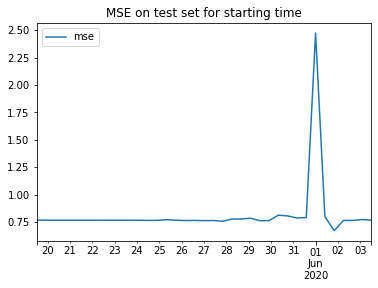

In [ ]:
error_df.plot(title="MSE on test set for starting time")